# Task 1

In [86]:
import numpy as np


class LinearRegression:
    """
    Fit function will use to train the model and updated weight and bias
    1. initializing the weight and bias with random
    2. For each epoch update the best weight and best bias if val_loss is decreasing
    3. Split the data into given batch size and calculate new weight and new bias
    4. Calculate the loss accordingly the regularization value if regularization is 0(default) than it will give normal LR and MSE loss or else it will L2 regression with given learning rate
    5. Predict with the weight and bias with given input data
    6. Calculate the MSE score with score function
    """
    def __init__(self, batch_size=32, regularization=0, max_epochs=100, patience=3, alpha=0.001):
        self.weight = None
        self.alpha = alpha
        self.batch_size = batch_size
        self.regularization = regularization
        self.max_epochs = max_epochs
        self.patience = patience
        self.bias = None
        self.error = []
        self.steps = []
        self.l2_error = []
        self.l2_loss = []
        self.mse_loss = []

    def mean_squared(self, X, target):
        """
        MSE calulated
        :param X: input Data
        :param target: Original Output data
        :return: MSE value

        Finding the mean squared error by the given formula
        """
        squared_error = ((np.dot(X, self.weight) + self.bias) - target) ** 2
        return np.sum(squared_error) / len(target)

    def gradient(self, X, y):
        """
        for mse which we will subtract from self.weight in normal regularization

        :param X: input Data
        :param y: Output Original
        :return: gradient
        """
        # print(self.weight.shape,self.bias.shape,X.shape)
        # pred_y = (np.dot(self.weight.T,X.T)+self.bias)
        # print(pred_y.shape)
        # print(y.shape)
        # residual_error = pred_y-y.T
        # print("Residual error")
        # print(residual_error.shape)
        # dot_prod = np.dot(residual_error,X)
        # print(dot_prod.shape)
        # return (2/len(y))* dot_prod

        error = (np.dot(X, self.weight) + self.bias) - y
        sum_of_error = np.sum(error)
        return (2 / len(y)) * sum_of_error

    def l2_regularization(self, X, y, reg_lambda_term):
        """
        Will calculate the l2 loss as well as normal loss when lambda is zero
        :param X: input_x
        :param y: ouput original y
        :param reg_lambda_term: lambda term for L2
        :return:
        """
        squared_error = np.sum(((np.dot(X, self.weight) + self.bias) - y) ** 2)
        normal_regularization_term = np.mean(squared_error)
        return normal_regularization_term + reg_lambda_term

    def l2_gradient(self, X, y):
        """
        Will calculate l2_gradient to subtract for derivative of weight
        :param X: input_x
        :param y: ouput original y
        :return:
        """
        error_term = ((np.dot(X, self.weight) + self.bias) - y) # error term
        dot_product = np.dot(X.T, error_term) # dot product of X transpose with error term
        regularized_term = (self.regularization * self.weight) # lambda multiply with w
        return (1 / len(y)) * dot_product + regularized_term

    def gradient_descent_l2(self, X, y, batch_size, alpha, regularization):
        """
        Here the l2 loss will be calculated and weight and bias will be updated accordingly for each batch
        :param X: input_x
        :param y: ouput original y
        :param batch_size: batch size default to 32
        :param alpha: alpha which  learning rate
        :param regularization: lab=mbda term
        :return: error per batch
        """
        self.regularization = regularization
        # calculating total no. of batches
        n = X.shape[0] // batch_size
        i = 0
        error = []
        # iterate each batch
        for i in range(n + 1):
            start_val = i * batch_size
            end_val = (i + 1) * batch_size
            input_x = X[start_val:end_val, :]  # input batch value
            target = y[start_val:end_val]  # original output batch terms
            output = input_x @ self.weight + self.bias  # predicted term
            sum_of_square_of_weight = np.sum(np.square(self.weight))
            lambda_2m = (self.regularization / 2 * batch_size) 
            reg_lambda_term = lambda_2m * sum_of_square_of_weight  # calculate reg lambda term
            self.l2_loss.append(
                self.l2_regularization(input_x, target, reg_lambda_term))  # appending the reg loss for each small batch
            der_weight = self.weight - alpha * self.l2_gradient(input_x, target)  # derivatives if weight
            self.weight = der_weight
            der_bias = self.bias - alpha * ((1 / len(output)) * np.sum(output - target))
            self.bias = der_bias
            error.append(self.l2_regularization(input_x, target, reg_lambda_term))  # appending each batch loss
        if X.shape[0] % batch_size != 0:
            star_val = i * batch_size
            input_x = X[star_val:X.shape[0]]
            target = y[star_val:X.shape[0]]
            output = input_x @ self.weight + self.bias  # predicted term
            sum_of_square_of_weight = np.sum(np.square(self.weight))
            lambda_2m = (self.regularization / 2 * batch_size)
            reg_lambda_term = lambda_2m * sum_of_square_of_weight  # calculate reg lambda term
            self.l2_loss.append(
                self.l2_regularization(input_x, target, reg_lambda_term))  # appending the reg loss for each small batch
            der_weight = self.weight - alpha * self.l2_gradient(input_x, target)  # derivatives if weight
            self.weight = der_weight
            der_bias = self.bias - alpha * ((1 / len(output)) * np.sum(output - target)) # derivatives of bias
            self.bias = der_bias
            error.append(self.l2_regularization(input_x, target, reg_lambda_term))  # appending each batch loss
        return np.mean(error)  # Mean of all error

    def fit(self, X, y, batch_size=32, max_epochs=100, alpha=0.01, regularization=0, patience=3):
        """
        function will give the best weight and best bias by calculating the best validation loss initializing alpha batch size and patience value
        :param X: input
        :param y: output original
        :param batch_size: default to 32
        :param max_epochs: amx steps default to 100
        :param alpha: learning rate default to 0.01
        :param regularization: lambda term default to zero
        :param patience: default to 3
        :return: none
        """
        nSamples, nFeatures = X.shape
        self.weight = np.random.randn(X.shape[1], y.shape[1])  # initializing random normalized weight
        self.bias = np.random.randn(1, y.shape[1])  # initializing random normalized bias
        # 10 % of validating set and 10 % of train set
        val_set_num_start = int(0.9 * nSamples)
        val_X = X[val_set_num_start:, :]
        val_y = y[val_set_num_start:, :]
        # train set 90%
        X = X[:val_set_num_start, :]
        y = y[:val_set_num_start, :]
        best_weights = None  # initialize best weights
        best_bias = None  # initialize best bias
        best_val_loss = float('inf')  # initialize best val loss default to inf
        no_improvement = 0  # for patience initialize it
        # iterating to max_epochs
        for i in range(max_epochs):
            self.steps.append(i)  # used for plotting
            self.l2_error.append(self.gradient_descent_l2(X, y, batch_size, alpha,
                                                          regularization))  # used for plotting and get the updated weight and bias for each epoch
            val_pred = val_X @ self.weight + self.bias  # validation set prediction
            lambda_2m = (self.regularization / 2 * batch_size)
            sum_of_square_of_weight = np.sum(np.square(self.weight))
            reg_lambda_term = lambda_2m * sum_of_square_of_weight  # reg _labda  term
            val_loss = np.mean(np.square(val_pred - val_y)) + reg_lambda_term  # validation loss prediction
            # if the validation loss is decreasing than then we will not change the no_improvement variable else increase
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_weights = self.weight.copy()  # make a copy
                best_bias = self.bias.copy() # make a copy
                no_improvement = 0 # change it to zero
            else:
                no_improvement += 1 # increment value
                if no_improvement == patience: # check for the patience value
                    break
        self.weight = best_weights # re-initialize withe new weight and bias
        self.bias = best_bias # re-initialize withe new weight and bias
        # print(best_bias,best_weights)
        # print(self.weight, self.bias)

    # def gradient_descent(self, X, y, batch_size, alpha):
    #     """
    #     calculating gradient_descent of each batch
    #     :param X:
    #     :param y:
    #     :param batch_size:
    #     :param alpha:
    #     :return:
    #     """
    #     sample, feature = X.shape
    #     output = y
    #     # self.weight = np.random.randn(feature, y.shape[1])
    #     # self.bias = np.random.randn(1, y.shape[1])
    #     n = X.shape[0] // batch_size
    #     i = 0
    #     error = []
    #     for i in range(n + 1):
    #         input = X[i * batch_size:(i + 1) * batch_size]
    #         target = y[i * batch_size:(i + 1) * batch_size]
    #         output = input @ self.weight + self.bias
    #         self.mse_loss.append(np.mean(np.square(output - target)))
    #         self.weight = self.weight - alpha * self.gradient(input, target)
    #         self.bias = self.bias - alpha * ((1 / len(output)) * np.sum(output - target))
    #         error.append(self.mean_squared(input, target))
    #     if X.shape[0] % batch_size != 0:
    #         input = X[i * batch_size:X.shape[0]]
    #         target = y[i * batch_size:X.shape[0]]
    #         output = input @ self.weight + self.bias
    #         self.mse_loss.append(np.mean(np.square(output - target)))
    #         self.weight = self.weight - alpha * self.gradient(input, target)
    #         self.bias = self.bias - alpha * ((1 / len(output)) * np.sum(output - target))
    #         error.append(self.mean_squared(input, target))
    #         i = i + 1
    #     return np.mean(error)
    #
    # def fit_normal(self, X, y, batch_size=32, max_epochs=100, alpha=0.01, patience=3):
    #     nSamples, nFeatures = X.shape
    #     self.weight = np.random.randn(nFeatures, y.shape[1])
    #     self.bias = np.random.randn(1, y.shape[1])
    #
    #     val_X = X[int(0.9 * nSamples):, :]
    #     val_y = y[int(0.9 * nSamples):, :]
    #     X = X[:int(0.9 * nSamples), :]
    #     y = y[:int(0.9 * nSamples), :]
    #     best_weights = None
    #     best_bias = None
    #     best_val_loss = float('inf')
    #     no_improvement = 0
    #     for i in range(max_epochs):
    #         self.steps.append(i)
    #         self.error.append(self.gradient_descent(X, y, batch_size, alpha))
    #         val_pred = val_X @ self.weight + self.bias
    #         val_loss = np.mean(np.square(val_pred - val_y))
    #         if val_loss < best_val_loss:
    #             best_val_loss = val_loss
    #             best_weights = self.weight.copy()
    #             best_bias = self.bias.copy()
    #             no_improvement = 0
    #         else:
    #             no_improvement += 1
    #             if no_improvement == patience:
    #                 print("i", i)
    #                 break
    #     # print(best_bias,best_weights)
    #     # print(self.weight, self.bias)
    #     self.weight = best_weights
    #     self.bias = best_bias

    def predict(self, X):
        """
        Predicting the value taking the final best update weight and bias
        :param X: input
        :return: return predicted value
        """
        return np.dot(X, self.weight) + self.bias

    def score(self, X, y):
        """
        calculating the MSE value by predicting the from X input and calulating the squared term
        :param X:
        :param y:
        :return:
        """
        prediction = self.predict(X)
        squared_error = np.sum((prediction - y) ** 2)
        meanSquaredError = squared_error / (len(X) * len(y))
        return meanSquaredError


# **Task 2**

**Predicting with Sepal Length And Sepal Width to Petal Width**

After how many Steps it is getting stopped 100


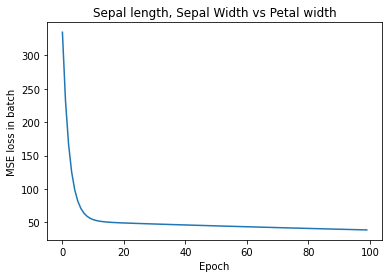

Score for MODEL1A:  0.08461305596039584
Best Weights:  [[-0.33508454]
 [ 0.76578128]]
Best bias:  [[0.7636354]]


In [87]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from matplotlib import pyplot as plt

irisDataSet = datasets.load_iris() # Loading the 
x=irisDataSet.data[:,:2] #Sepal Length And Sepal Width
y=irisDataSet.data[:,3:] #Petal Width
#Stratify is used to do equal split for each class (Iris Classe)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state= 7, stratify=irisDataSet.target)
model1A = LinearRegression() #initialize the model
model1A.fit(X_train,y_train,32,100,0.001,0,3) # Here regularization term is zero so it will work like normal linear regression
# print(model1A.predict(X_test))
print("After how many Steps it is getting stopped",len(model1A.steps))

plt.plot(model1A.steps,model1A.l2_error)
plt.title('Sepal length, Sepal Width vs Petal width')
plt.xlabel('Epoch')
plt.ylabel('MSE loss in batch')
plt.savefig('Model1A.png')
plt.show()

print("Score for MODEL1A: ",model1A.score(X_test,y_test) )
print("Best Weights: ",model1A.weight)
print("Best bias: ",model1A.bias)

# # L2 regression
# print("-------------------------------------------") 
# model1B = LinearRegression() #initialize the model
# model1B.fit(X_train,y_train,32,100,0.001,0.001,3) # Here regularization term is zero so it will work like normal linear regression
# # print(model1A.predict(X_test))
# print("After how many Steps it is getting stopped",len(model1B.steps))

# plt.plot(model1B.steps,model1B.l2_error)
# plt.title('Sepal length, Sepal Width vs Petal width')
# plt.xlabel('Epoch')
# plt.ylabel('L2 loss in batch')
# plt.show()

# print("Score for MODEL1A: ",model1B.score(X_test,y_test) )
# print("Best Weights: ",model1B.weight)
# print("Best bias: ",model1B.bias)


**Predicting with Petal Length And Petal Width to Sepal Length**

After how many Steps it is getting stopped 100


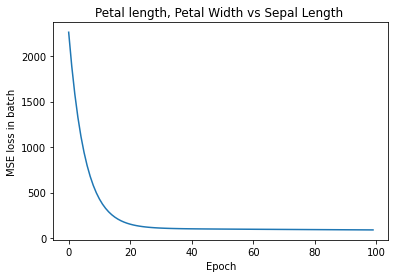

Score for MODEL2A:  0.15023524262116209
Best Weights:  [[ 1.68054545]
 [-1.04713209]]
Best bias:  [[0.16961436]]


In [92]:
irisDataSet = datasets.load_iris()
x=irisDataSet.data[:,2:4] #Petal Length And Petal Width
y=irisDataSet.data[:,:1] #Sepal Length
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state= 7, stratify=irisDataSet.target)
model2A = LinearRegression()
model2A.fit(X_train,y_train,32,100,0.001,0,3) # Here regularization term is zero so it will work like normal linear regression
# print(model1A.predict(X_test))
print("After how many Steps it is getting stopped",len(model2A.steps))

plt.plot(model2A.steps,model2A.l2_error)
plt.title('Petal length, Petal Width vs Sepal Length ')
plt.xlabel('Epoch')
plt.ylabel('MSE loss in batch')
plt.savefig('Model2A.png')
plt.show()

print("Score for MODEL2A: ",model2A.score(X_test,y_test) )
print("Best Weights: ",model2A.weight)
print("Best bias: ",model2A.bias)

# # L2 regression
# print("-------------------------------------------") 
# model2B = LinearRegression() #initialize the model
# model2B.fit(X_train,y_train,32,100,0.001,0.001,3) # Here regularization term is zero so it will work like normal linear regression
# # print(model1A.predict(X_test))
# print("After how many Steps it is getting stopped",len(model2B.steps))

# plt.plot(model2B.steps,model2B.l2_error)
# plt.title('Petal length, Petal Width vs Sepal Length ')
# plt.xlabel('Epoch')
# plt.ylabel('L2 loss in batch')
# plt.savefig('Model2B.png')
# plt.show()

# print("Score for MODEL2B: ",model2B.score(X_test,y_test) )
# print("Best Weights: ",model2B.weight)
# print("Best bias: ",model2B.bias)


**Predicting with Sepal Width and Petal Length to Petal Width**

After how many Steps it is getting stopped 100


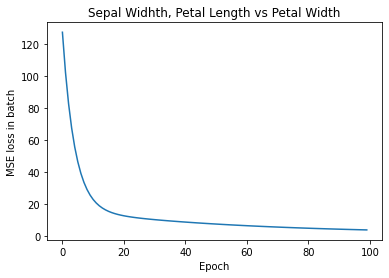

Score for MODEL3A:  0.005903867291210961
Best Weights:  [[-0.03279586]
 [ 0.56640901]]
Best bias:  [[-0.89001121]]
-------------------------------------------
After how many Steps it is getting stopped 100


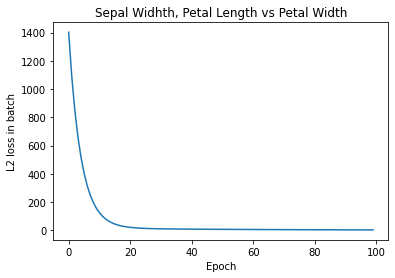

Score for MODEL3B:  0.008928269706307973
Best Weights:  [[0.24033962]
 [0.26660585]]
Best bias:  [[-0.50457037]]


In [89]:
irisDataSet = datasets.load_iris()
x=irisDataSet.data[:,1:3] #Sepal Width and Petal Length
y=irisDataSet.data[:,3:] #Petal Width
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state= 7, stratify=irisDataSet.target)
model3A = LinearRegression()
model3A.fit(X_train,y_train,32,100,0.001,0,3) # Here regularization term is zero so it will work like normal linear regression
# print(model1A.predict(X_test))
print("After how many Steps it is getting stopped",len(model3A.steps))

plt.plot(model3A.steps,model3A.l2_error)
plt.title('Sepal Widhth, Petal Length vs Petal Width')
plt.xlabel('Epoch')
plt.ylabel('MSE loss in batch')
plt.savefig('Model3A.png')
plt.show()
print("Score for MODEL3A: ",model3A.score(X_test,y_test))
print("Best Weights: ",model3A.weight)
print("Best bias: ",model3A.bias)

# L2 regression
print("-------------------------------------------") 
model3B = LinearRegression() #initialize the model
model3B.fit(X_train,y_train,32,100,0.001,0.001,3) # Here regularization term is zero so it will work like normal linear regression
# print(model1A.predict(X_test))
print("After how many Steps it is getting stopped",len(model3B.steps))

plt.plot(model3B.steps,model3B.l2_error)
plt.title('Sepal Widhth, Petal Length vs Petal Width')
plt.xlabel('Epoch')
plt.ylabel('L2 loss in batch')
plt.savefig('Model3B.png')
plt.show()

print("Score for MODEL3B: ",model3B.score(X_test,y_test) )
print("Best Weights: ",model3B.weight)
print("Best bias: ",model3B.bias)


**Predicting with Sepal Length and Petal Width to Sepal Width**

After how many Steps it is getting stopped 7


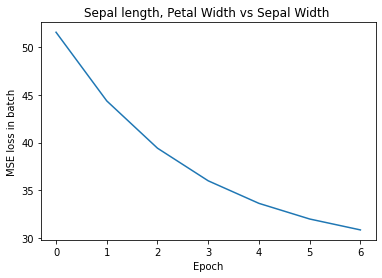

Score for MODEL4A:  0.0727866714224995
Best Weights:  [[0.61131758]
 [0.34498653]]
Best bias:  [[-1.42920436]]


In [90]:
irisDataSet = datasets.load_iris()
x=irisDataSet.data[:,::3] #Sepal Length and Petal Width
y=irisDataSet.data[:,1:2] #Sepal Width
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state= 7, stratify=irisDataSet.target)
model4A = LinearRegression()
model4A.fit(X_train,y_train,32,100,0.001,0,3) # Here regularization term is zero so it will work like normal linear regression
# print(model1A.predict(X_test))
print("After how many Steps it is getting stopped",len(model4A.steps))

plt.plot(model4A.steps,model4A.l2_error)
plt.title('Sepal length, Petal Width vs Sepal Width ')
plt.xlabel('Epoch')
plt.ylabel('MSE loss in batch')
plt.savefig('Model4A.png')
plt.show()
print("Score for MODEL4A: ",model4A.score(X_test,y_test) )
print("Best Weights: ",model4A.weight)
print("Best bias: ",model4A.bias)

# # L2 regression
# print("-------------------------------------------") 
# model4B = LinearRegression() #initialize the model
# model4B.fit(X_train,y_train,32,100,0.001,0.001,3) # Here regularization term is zero so it will work like normal linear regression
# # print(model1A.predict(X_test))
# print("After how many Steps it is getting stopped",len(model4B.steps))

# plt.plot(model4B.steps,model4B.l2_error)
# plt.title('Sepal length, Petal Width vs Sepal Width ')
# plt.xlabel('Epoch')
# plt.ylabel('L2 loss in batch')
# plt.show()

# print("Score for MODEL4B: ",model4B.score(X_test,y_test) )
# print("Best Weights: ",model4B.weight)
# print("Best bias: ",model4B.bias)


# Task 3

(1261, 36, 48)
(1261, 36)


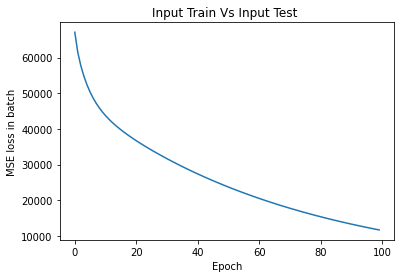

Mean Square Error for task 3:  0.008313792186663487
Root Mean Square Error for task 3:  0.06270653162069809


In [91]:
import numpy as np
import pandas as pd
import scipy.io as sio
from matplotlib import pyplot as plt

data_path = "/content/traffic_dataset.mat"

# The provided data is given in a `.mat` file.
# We can load it using the `scipy.io.loadmat` function.
mat = sio.loadmat(data_path)
input_train = mat['tra_X_tr']
output_train = mat['tra_Y_tr'].T
input_test = mat['tra_X_te']
output_test = mat['tra_Y_te'].T
adj_mat = mat['tra_adj_mat']

input_train = input_train.squeeze()
input_test = input_test.squeeze()

# Convert the sparse matrix to a dense matrix
data = []
test_data = []

for i in range(input_train.shape[0]):
    data.append(input_train[i].todense())

for i in range(input_test.shape[0]):
    test_data.append(input_test[i].todense())

# Convert the data to a numpy array
data = np.array(data)
test_data = np.array(test_data)

print(data.shape)
print(output_train.shape)

input_train = np.reshape(data, (1261, 1728))
output_train = np.reshape(output_train, (1261, 36))
input_test = np.reshape(test_data,(840,1728))
output_test = np.reshape(output_test,(840,36))
model =  LinearRegression()
model.fit(input_train,output_train,16,100,0.001,0.1,3)

plt.plot(model.steps,model.l2_error)
plt.title('Input Train Vs Input Test ')
plt.xlabel('Epoch')
plt.ylabel('MSE loss in batch')
plt.show()

mse = model.score(input_train,output_train)
print("Mean Square Error for task 3: ",model.score(input_test,output_test) )
print("Root Mean Square Error for task 3: ",np.sqrt(mse))